In [ ]:
!pip install yfinance prophet

# Import libraries

In [703]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Prepare data

In [706]:
df = yf.download('GC=F', start='2010-01-01', end='2025-05-24')[['Close']]
df = df.reset_index()
df.columns = ['Date', 'Price_Close']
df = df.rename(columns={'Date': 'ds', 'Price_Close': 'y'})
df = df.dropna()
df.head()

[*********************100%***********************]  1 of 1 completed


,ds,y
0,2010-01-04,1117.699951
1,2010-01-05,1118.099976
2,2010-01-06,1135.900024
3,2010-01-07,1133.099976
4,2010-01-08,1138.199951


# Data overview

In [709]:
df.isnull().sum()
df.shape

(3870, 2)

### Gold Price Trend

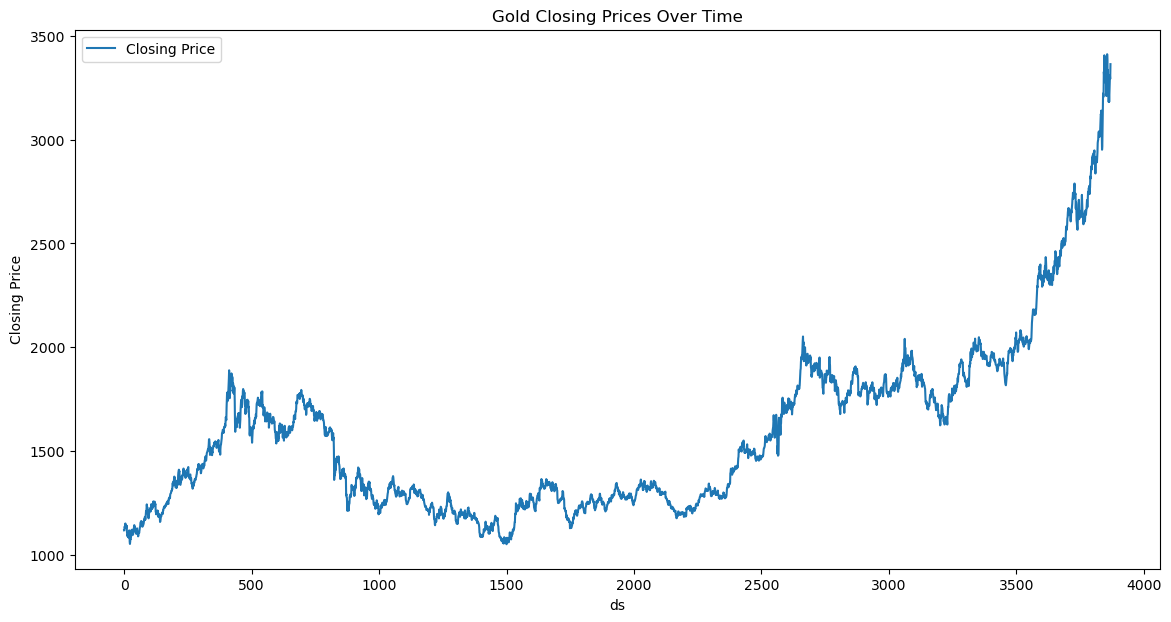

In [712]:
plt.figure(figsize=(14, 7))
plt.plot(df['y'], label='Closing Price')
plt.title('Gold Closing Prices Over Time')
plt.xlabel('ds')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# Forecast with Prophet

In [714]:
model = Prophet()
model.fit(df)

future = model.make_future_dataframe(periods=0)
forecast = model.predict(future)

df['yhat'] = forecast['yhat']
df['residual'] = df['y'] - df['yhat']


02:16:03 - cmdstanpy - INFO - Chain [1] start processing
02:16:06 - cmdstanpy - INFO - Chain [1] done processing


# Feature Engineering for Machine Learning

In [716]:
# Create lag features from residuals
df['lag1'] = df['residual'].shift(1)
df['lag2'] = df['residual'].shift(2)
df['lag3'] = df['residual'].shift(3)

# Add time-based features
df['dayofweek'] = df['ds'].dt.dayofweek
df['month'] = df['ds'].dt.month

df_ml = df.dropna()


# Prepare Data for Predicting the residuals

In [718]:
# Feature and target setup
X = df_ml[['lag1', 'lag2', 'lag3', 'dayofweek', 'month']]
y = df_ml['residual']

# Split data into train (70%), validation (15%), test (15%)
n_total = len(df_ml)
n_train = int(n_total * 0.7)
n_valid = int(n_total * 0.15)

X_train, y_train = X[:n_train], y[:n_train]
X_valid, y_valid = X[n_train:n_train + n_valid], y[n_train:n_train + n_valid]
X_test, y_test = X[n_train + n_valid:], y[n_train + n_valid:]

# Train XGBoost Model

In [720]:
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    objective='reg:squarederror'
)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

# Make Predictions and Final Forecast result

In [722]:
# Predict residuals using XGBoost
residual_preds = xgb_model.predict(X_test)
prophet_pred = df_ml['yhat'].iloc[-len(X_test):].values
final_pred = prophet_pred + residual_preds
true_values = df_ml['y'].iloc[-len(X_test):].values


# Evaluate Model Performance

In [724]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    epsilon = 1e-10
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Dự báo residual trên tập train
residual_preds_train = xgb_model.predict(X_train)
prophet_pred_train = df_ml['yhat'].iloc[:len(X_train)].values
final_pred_train = prophet_pred_train + residual_preds_train
true_values_train = df_ml['y'].iloc[:len(X_train)].values

# Đánh giá trên tập train
mae_train = mean_absolute_error(true_values_train, final_pred_train)
rmse_train = mean_squared_error(true_values_train, final_pred_train, squared=False)
mape_train = mean_absolute_percentage_error(true_values_train, final_pred_train)

print("Train set evaluation:")
print(f"MAE: {mae_train:.2f}")
print(f"MAPE: {mape_train:.2f}%")
print(f"RMSE: {rmse_train:.2f}")

# Đánh giá trên tập test
mae_test = mean_absolute_error(true_values, final_pred)
rmse_test = mean_squared_error(true_values, final_pred, squared=False)
mape_test = mean_absolute_percentage_error(true_values, final_pred)

print("\nTest set evaluation:")
print(f"MAE: {mae_test:.2f}")
print(f"MAPE: {mape_test:.2f}%")
print(f"RMSE: {rmse_test:.2f}")


Train set evaluation:
MAE: 7.89
MAPE: 0.57%
RMSE: 10.89

Test set evaluation:
MAE: 52.99
MAPE: 2.25%
RMSE: 86.90


In [725]:
results_df = pd.DataFrame({
    'Date': df_ml['ds'].iloc[-len(X_test):].values,
    'Actual Price': true_values,
    'Predicted Price': final_pred
})
print(results_df)


          Date  Actual Price  Predicted Price
0   2023-02-01   1927.800049      1928.454700
1   2023-02-02   1916.300049      1928.540560
2   2023-02-03   1862.900024      1919.064810
3   2023-02-06   1866.199951      1817.440684
4   2023-02-07   1871.699951      1860.549540
..         ...           ...              ...
576 2025-05-19   3228.899902      3037.196408
577 2025-05-20   3280.300049      2984.571195
578 2025-05-21   3309.300049      2980.377358
579 2025-05-22   3292.300049      3034.886641
580 2025-05-23   3363.600098      3038.590177

[581 rows x 3 columns]


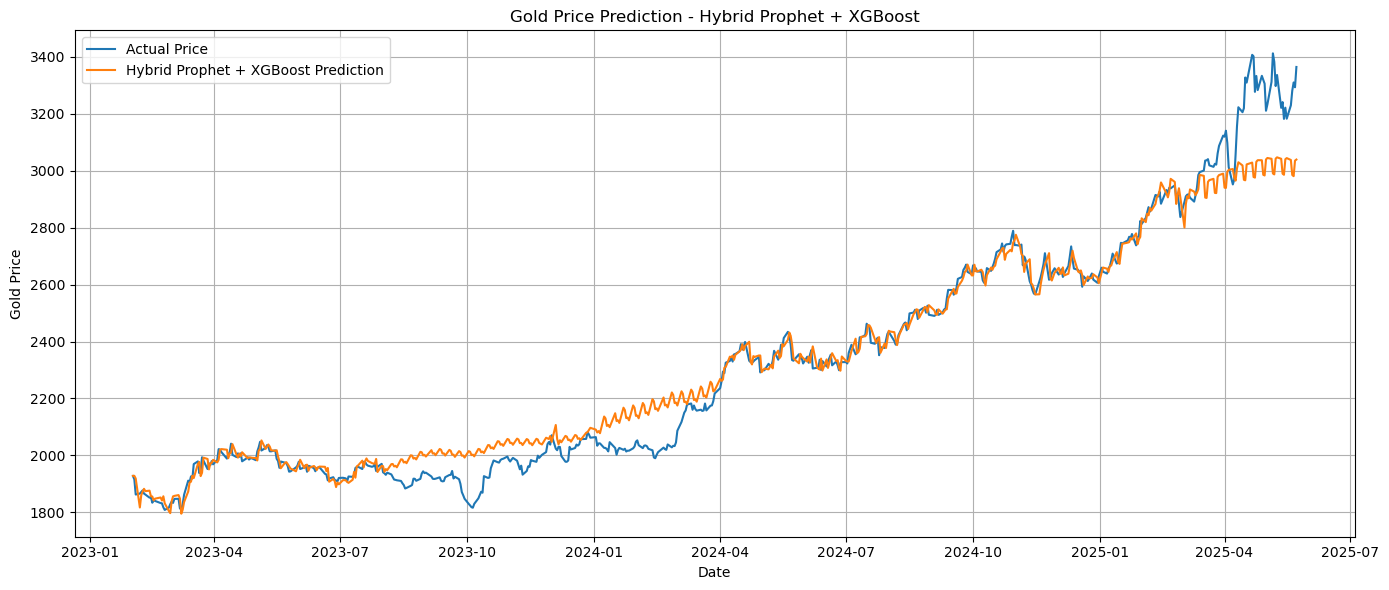

In [726]:
plt.figure(figsize=(14,6))
plt.plot(df_ml['ds'].iloc[-len(X_test):], true_values, label='Actual Price')
plt.plot(df_ml['ds'].iloc[-len(X_test):], final_pred, label='Hybrid Prophet + XGBoost Prediction')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Gold Price Prediction - Hybrid Prophet + XGBoost')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Fine-tuning XGBoost Model Using Optuna

In [728]:
import warnings
warnings.filterwarnings("ignore")

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42,
        'objective': 'reg:squarederror',
        'verbosity': 0
    }

    model = XGBRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )
    preds = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, preds)
    return mae

# Run optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best hyperparameters:", study.best_params)

# Train best model on combined train + validation
best_params = study.best_params
best_params.update({
    'random_state': 42,
    'objective': 'reg:squarederror',
    'verbosity': 0
})

X_train_final = X[:n_train + n_valid]
y_train_final = y[:n_train + n_valid]

final_model = XGBRegressor(**best_params)
final_model.fit(X_train_final, y_train_final)

# Predict residuals on test set
residual_preds = final_model.predict(X_test)

# Add back Prophet predictions
prophet_pred = df_ml['yhat'].iloc[-len(X_test):].values
final_pred = prophet_pred + residual_preds
true_values = df_ml['y'].iloc[-len(X_test):].values

# Evaluate
mae = mean_absolute_error(true_values, final_pred)
rmse = mean_squared_error(true_values, final_pred, squared=False)

print(f"MAE on test set: {mae:.2f}")
print(f"RMSE on test set: {rmse:.2f}")


Best hyperparameters: {'n_estimators': 272, 'max_depth': 3, 'learning_rate': 0.025834684985093045, 'subsample': 0.814218588570504, 'colsample_bytree': 0.9754035480312587, 'gamma': 2.6157827797172746, 'reg_alpha': 0.49645139742768857, 'reg_lambda': 0.33725298878297433}
MAE on test set: 44.59
RMSE on test set: 67.50


# Save the models

In [730]:
import joblib
joblib.dump(model, 'prophet_model.pkl')


['prophet_model.pkl']

In [731]:
import joblib
joblib.dump(final_model, 'xgb_residual_model.pkl')

['xgb_residual_model.pkl']

# Predict future gold price

### Load the saved models

In [734]:
import joblib
model = joblib.load("prophet_model.pkl")  # tên file bạn đã lưu
from xgboost import XGBRegressor
xgb_model = XGBRegressor()
xgb_model.load_model("xgb_model.json")  # tên file bạn đã lưu


### Create the next day for Prophet to forecast

In [736]:
future_next_day = model.make_future_dataframe(periods=1)
forecast_next_day = model.predict(future_next_day)
next_prophet = forecast_next_day['yhat'].iloc[-1]

### Create input features for XGBoost

In [738]:
latest_residuals = df['y'] - forecast_next_day['yhat'][:len(df)]
df['residual'] = latest_residuals
df['lag1'] = df['residual'].shift(1)
df['lag2'] = df['residual'].shift(2)
df['lag3'] = df['residual'].shift(3)
df['dayofweek'] = df['ds'].dt.dayofweek
df['month'] = df['ds'].dt.month
latest_input = df[['lag1', 'lag2', 'lag3', 'dayofweek', 'month']].iloc[-1:]


### Predict residual using XGBoost

In [744]:
residual_pred = xgb_model.predict(latest_input)[0]

### Final forecast for next day

In [746]:
from datetime import timedelta
last_day = df_ml['ds'].iloc[-1]
next_day = last_day + timedelta(days=1)
print(f"Gold price prediction for the following day {next_day.strftime('%d-%m-%Y')}: {final_pred[-1]:.2f}")


Gold price prediction for the following day 24-05-2025: 3118.56
